In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [34]:
# User input
K = 2
a = 0 
b = 1
N = 100
N_test = int(0.7 * N)
sigma = 0.1
mean = 1

In [35]:
def split_data(X, Y, Ntrain):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]
    Xtest = X[test_idx]
    Ytest = Y[test_idx]
    return Xtrain, Ytrain, Xtest, Ytest
def vander(X, K):
    N = len(X)
    V = np.zeros((N, K))
    for i in range(K):
        V[:,i] = X ** i
    return V

def define_dataset(K, a, b, N, sigma):
    X = np.linspace(a, b, N)
    Phi = vander(X, K)
    theta_true = np.ones((K,))
    Y = Phi @ theta_true + np.random.normal(0, sigma, N)
    return X, Y

In [36]:
# MLE and MAP Function definition
# def f_MLE(X, Y):
#     return lambda theta: 1/2 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y)) ** 2

def grad_f_MLE(X, Y, theta):
    return vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y)

# def f_MAP(X, Y, l):
#     return lambda theta: 1/2 * (np.linalg.norm((vander(X, len(theta)) @ theta) - Y)) ** 2 + (l/2 * np.linalg.norm(theta)**2)

def grad_f_MAP(l):
    return lambda X, Y, theta: vander(X, len(theta)).T @ ((vander(X, len(theta)) @ theta) - Y) + 2 * l * theta

In [37]:
def GD(grad_f, x0, tolf, tolx, kmax, D, alpha=1e-2):
    k=0
    X, Y = D
    x = np.zeros((len(x0),kmax))
    x[:,k] = x0

    grads = np.zeros((len(x0),kmax))
    grads[:,k] = grad_f(X, Y, x0)

    while (np.linalg.norm(grad_f(X, Y, x[:,k])) >= tolf and k < kmax-1):
        step = alpha * grad_f(X, Y, x[:,k])
        x[:,k+1] = x[:,k] - step
        grads[:,k+1] = grad_f(X, Y, x[:,k+1])
        if(np.linalg.norm( x[:,k+1] - x[:,k], 2) < tolx ):
            break
        k = k+1
    return x[:,k]
    
def shuffle_data(X, Y, size):
    N = len(X)
    indexes = np.arange(N)
    np.random.shuffle(indexes)

    X_shuffle = X[indexes]
    Y_shuffle = Y[indexes]

    return X_shuffle, Y_shuffle

def SGD(grad_l, w0, D, batch_size, n_epochs, alpha=1e-5):
    X, Y = D
    N = len(X)

    n_batch_per_epoch = N//batch_size
    tot_batch = n_batch_per_epoch * n_epochs
    
    w = np.array(w0)
    w_vector = np.zeros((tot_batch, len(w0)))
      
    for epoch in range(n_epochs):
        X_shuffle, Y_shuffle = shuffle_data(X, Y, N//batch_size)
        
        for b in range (n_batch_per_epoch):  
            n = b*batch_size
            m = (b+1)*batch_size
            Mx = X_shuffle[n:m]
            My = Y_shuffle[n:m]

            w = w - alpha * grad_l(Mx, My, w)
            w_vector[epoch*n_batch_per_epoch + b, :] = w
        
    return w_vector[-1, :]

In [38]:
X, Y = define_dataset(K, a, b, N, sigma)
X_train, Y_train, X_test, Y_test = split_data(X, Y, N_test)
D = (X, Y)

In [39]:
def MLE(D, K, method):
    X, Y = D
    theta_mle = None
    match(method):
        case "GD":
            theta_mle = GD(grad_f_MLE, np.zeros((K,)), 1e-6, 1e-6, 1000, D)
        case "SGD":
            w0 = np.random.normal(mean, sigma, K)
            theta_mle = SGD(grad_f_MLE, w0, D, 10, 30)
            pass
        case "NE": # NE stands for Normal Equation
            Phi = vander(X, K)
            A = Phi.T @ Phi
            b = Phi.T @ Y
            try:
                L = scipy.linalg.cholesky(A, lower=True)
                y = scipy.linalg.solve_triangular(L, b, lower=True)
                theta_mle = scipy.linalg.solve_triangular(L.T, y)
            except:
                theta_mle = np.linalg.solve(A, b)
    return theta_mle

In [40]:
def polynomial_regression(X, k, theta):
    Phi = vander(X, k)
    return Phi @ theta

def error(theta, TE):
    X, Y = TE
    N = len(Y)
    Y_pred = polynomial_regression(X, len(theta), theta)
    return 1/N * (np.linalg.norm(Y_pred - Y)**2)


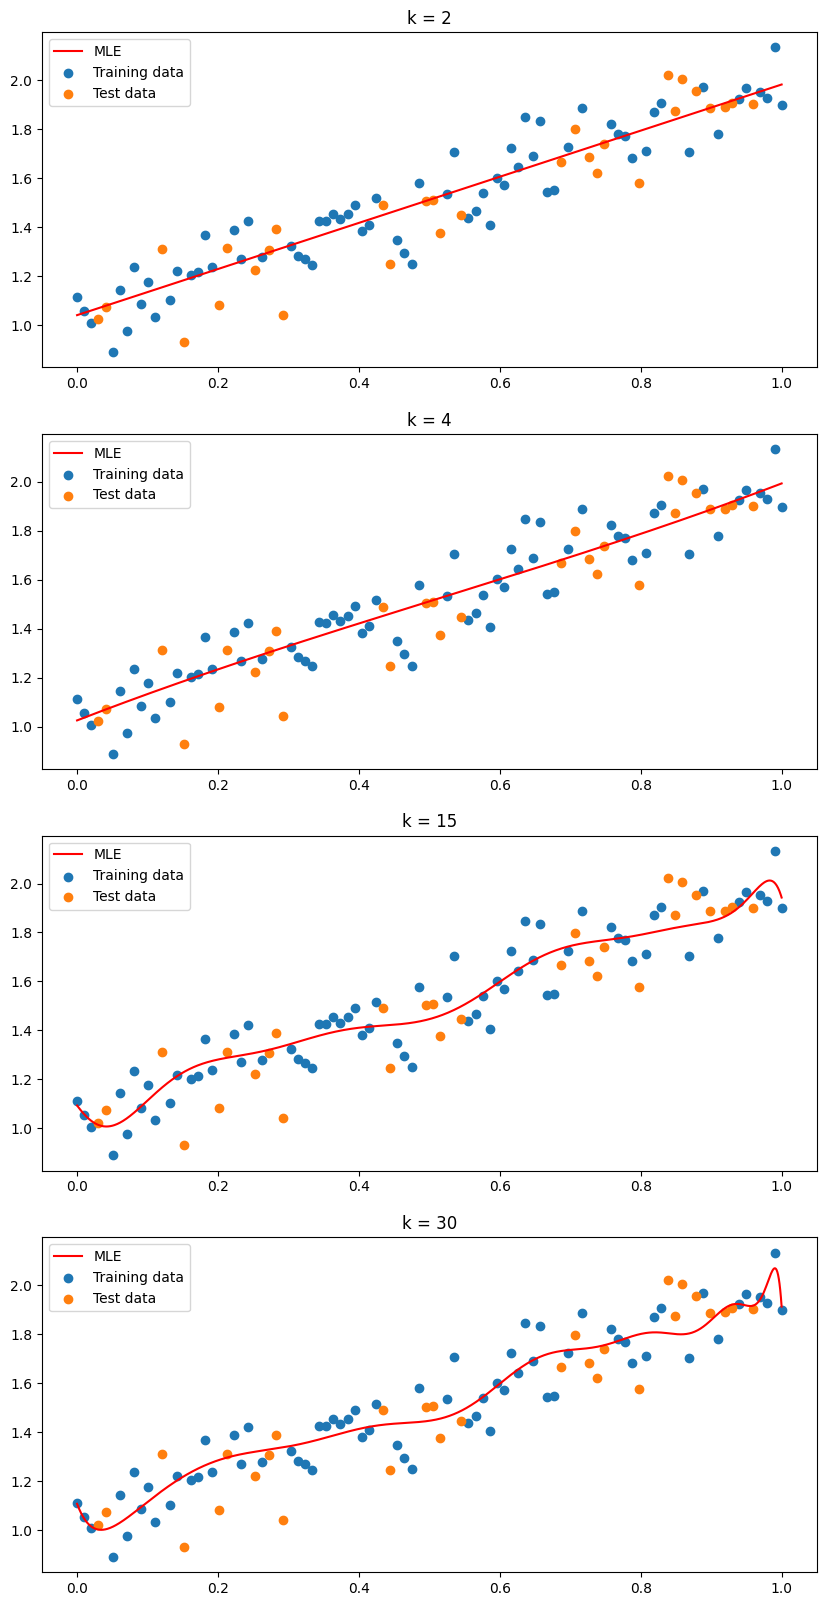

In [41]:
k_vector_mle = [2, 4, 15, 30]
theta_mle_vector = []

for k in k_vector_mle:
    theta_mle_k = MLE((X_train, Y_train), k, "NE")
    theta_mle_vector.append(theta_mle_k)

fig, ax = plt.subplots(len(k_vector_mle), figsize = (10, 20))

for i in range(len(k_vector_mle)):
    XX = np.linspace(a, b, 1000)
    YY = polynomial_regression(XX, k_vector_mle[i], theta_mle_vector[i])
    ax[i].plot(XX, YY, label = "MLE", color = "red")
    ax[i].scatter(X_train, Y_train, label = "Training data")
    ax[i].scatter(X_test, Y_test, label = "Test data")
    ax[i].set_title("k = " + str(k_vector_mle[i]))
    ax[i].legend()

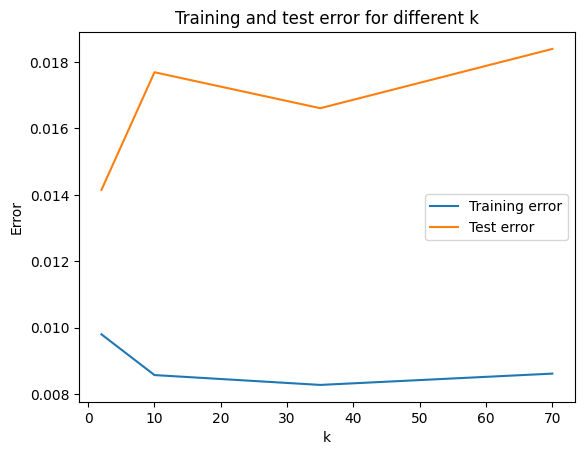

In [42]:
k_vector_mle = [2, 10, 35, 70]
errors_train_mle = []
errors_test_mle = []

for k in k_vector_mle:
    theta_mle_k = MLE((X_train, Y_train), k, "NE")
    errors_train_mle.append(error(theta_mle_k, (X_train, Y_train)))
    errors_test_mle.append(error(theta_mle_k, (X_test, Y_test)))


plt.plot(k_vector_mle, errors_train_mle, label = "Training error")
plt.plot(k_vector_mle, errors_test_mle, label = "Test error")
plt.legend()
plt.title("Training and test error for different k")
plt.xlabel("k")
plt.ylabel("Error")
plt.show()

In [43]:
def MAP(D, K, lmbda, method):
    X, Y = D
    theta_map = None
    match(method):
        case "GD":
            theta_map = GD(grad_f_MAP(lmbda), np.zeros((K,)), 1e-6, 1e-6, 1000, D)
        case "SGD":
            w0 = np.random.normal(mean, sigma, K)
            theta_map = SGD(grad_f_MAP(lmbda), w0, D, 10, 1000)
        case "NE": # NE stands for Normal Equation
            Phi = vander(X, K)
            A = Phi.T @ Phi + (lmbda * np.eye(K))
            b = Phi.T @ Y
            try:
                L = scipy.linalg.cholesky(A, lower=True)
                y = scipy.linalg.solve_triangular(L, b, lower=True)
                theta_map = scipy.linalg.solve_triangular(L.T, y)
            except:
                theta_map = np.linalg.solve(A, b)
    return theta_map

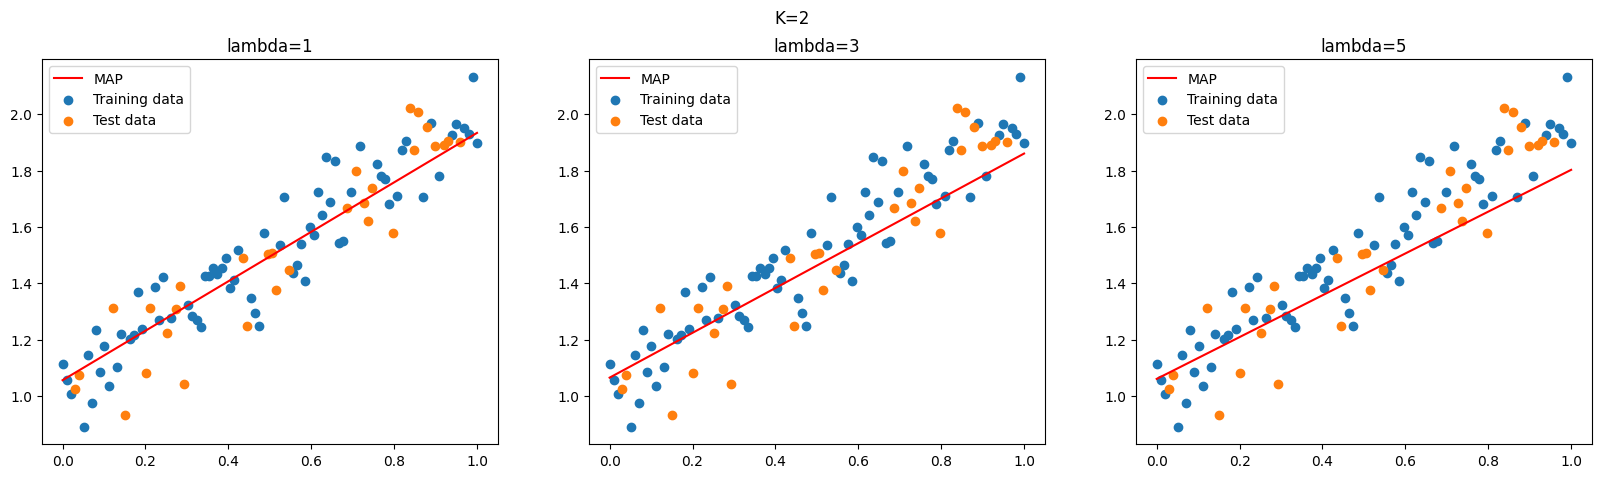

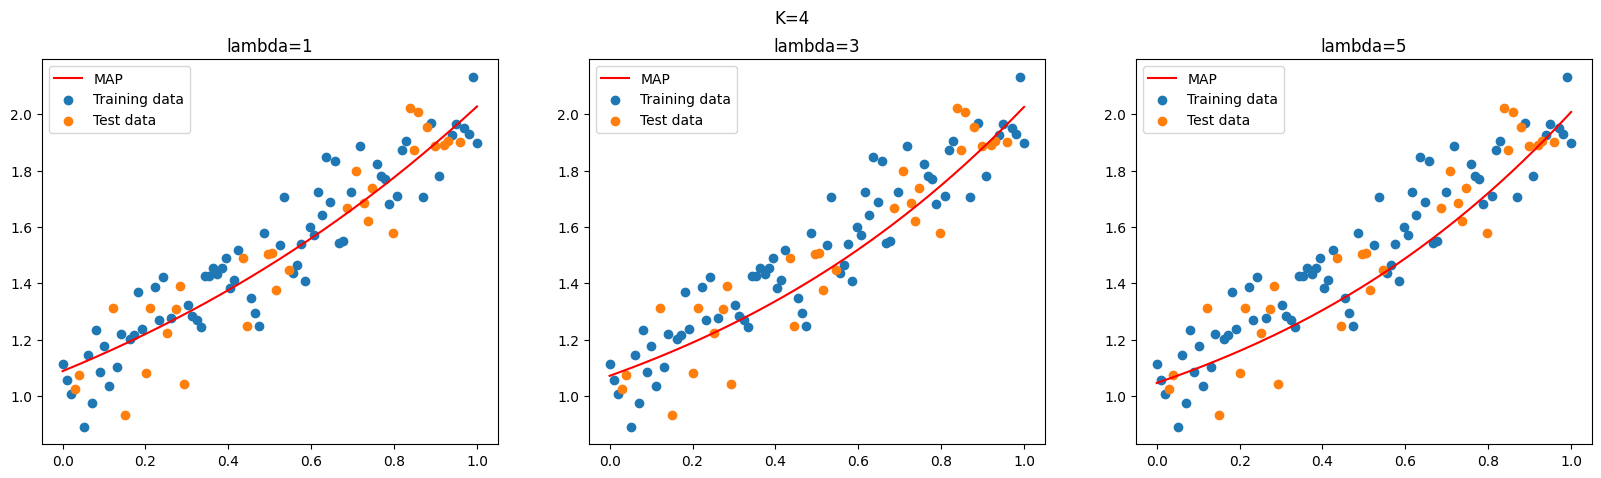

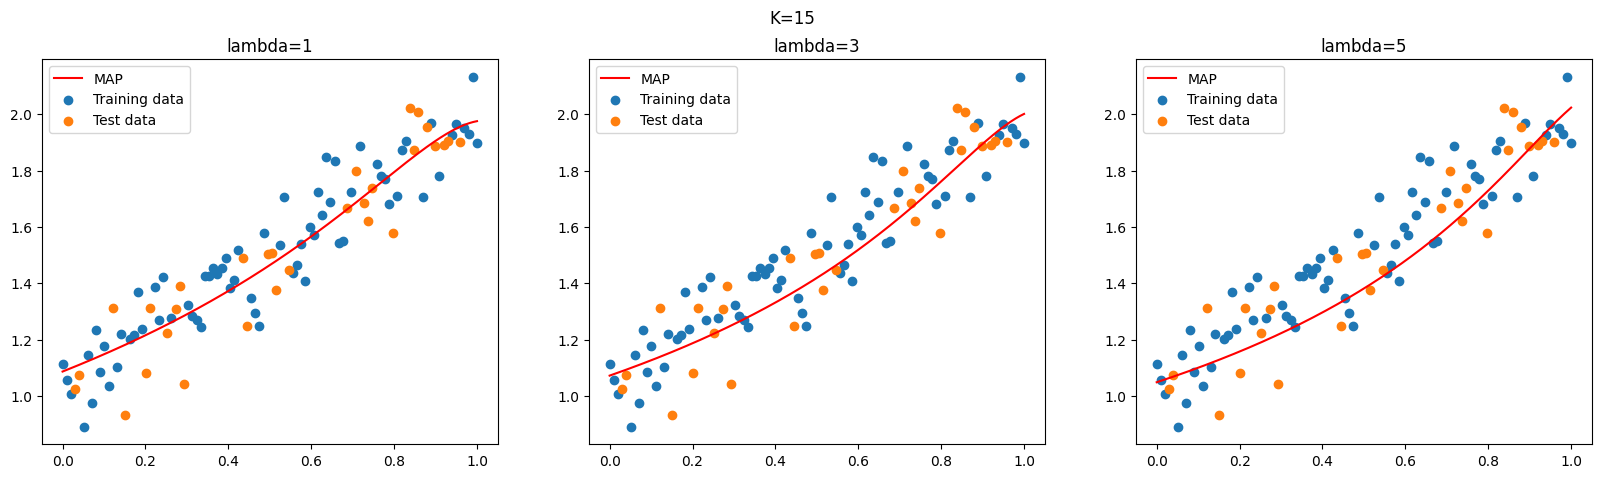

In [44]:
# X_test, Y_test, X_train, Y_train = split_data(X, Y, N_test)

k_vector_map = [2, 4, 15]
l = [1, 3, 5]
theta_map_k = []

for k in k_vector_map:
    theta_map_l = []
    for i in l:
        theta_map_l.append(MAP((X_train, Y_train), k, i, "NE"))
    theta_map_k.append(theta_map_l)     

for i in range(len(k_vector_map)):
    k_curr = k_vector_map[i]
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={k_curr}")
    for j in range(len(l)):
        l_curr = l[j]
        theta_map = theta_map_k[i][j]
        XX = np.linspace(a, b, 1000)
        YY = polynomial_regression(XX, k_curr, theta_map)
        plt.subplot(1, 3, j + 1)
        plt.plot(XX, YY, label = "MAP", color = "red")
        plt.scatter(X_train, Y_train, label = "Training data")
        plt.scatter(X_test, Y_test, label = "Test data")
        plt.title(f"lambda={l_curr}")
        plt.legend()

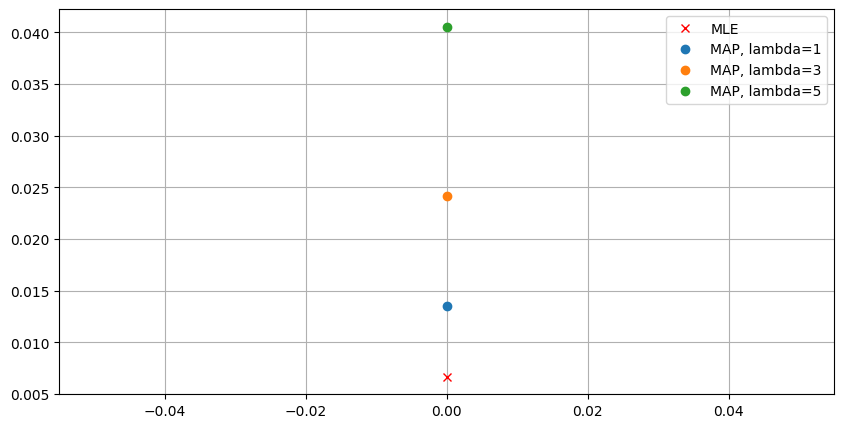

In [45]:
K_bigger = 70
l = [1, 3, 5]



theta_mle_bigger = MLE((X_test, Y_test), K_bigger, "NE")
thetas_map_bigger = [MAP((X_test, Y_test), K_bigger, i, "NE") for i in l]

mle_error = error(theta_mle_bigger, (X_test, Y_test))
map_errors = [error(theta, (X_test, Y_test)) for theta in thetas_map_bigger]

legend = ["MLE"] + [f"MAP, lambda={i}" for i in l]

plt.figure(figsize = (10, 5))
plt.plot(mle_error, 'xr')
for i in range(len(l)):
    plt.plot(map_errors[i], 'o')
plt.legend(legend)
plt.grid()


In [46]:
def theta_error(theta, k):
    theta_true = np.ones(k)
    if len(theta > k):
        theta_true = np.pad(theta_true, (0, len(theta)-len(theta_true)), 'constant', constant_values=(0, 0))
    
    return np.linalg.norm(theta_true - theta, ord=2)/np.linalg.norm(theta_true, ord=2)

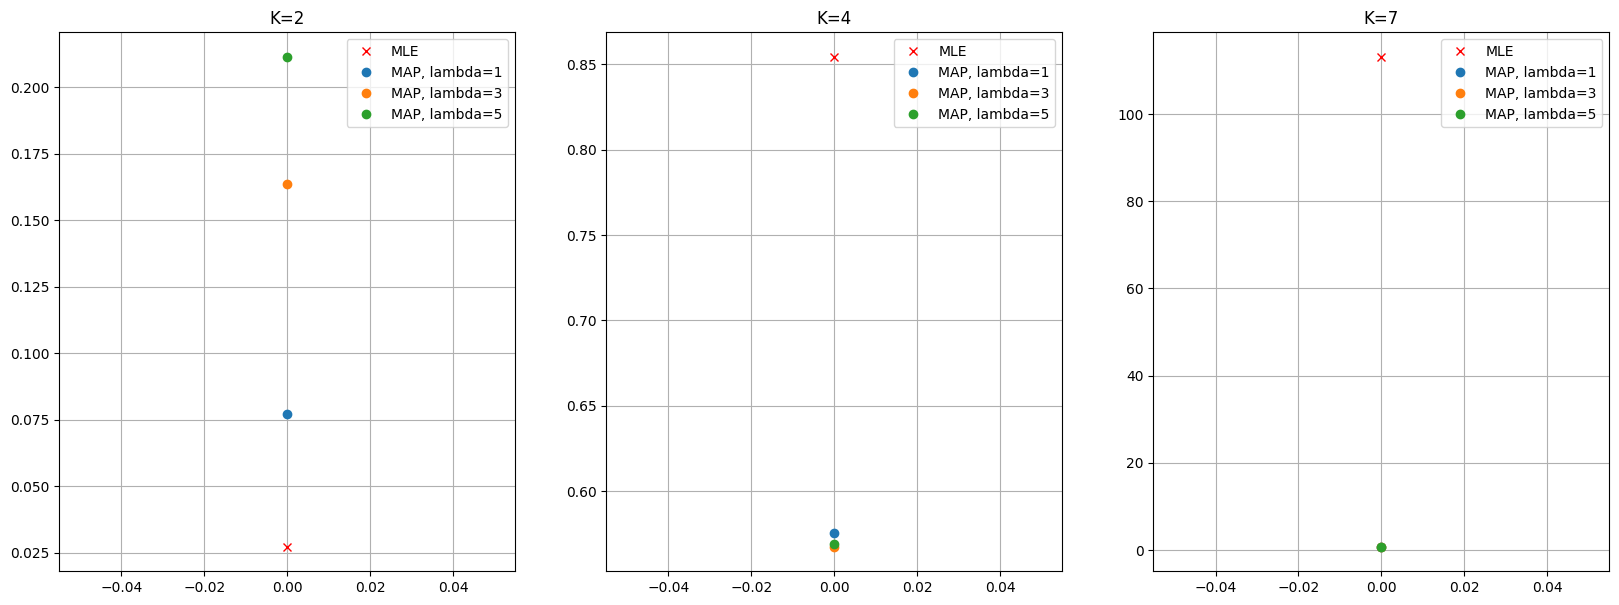

In [47]:
k_vector_comparison = [2, 4, 7]
l_comparison = [1, 3, 5]


legend = ["MLE"] + [f"MAP, lambda={i}" for i in l_comparison]

plt.figure(figsize = (20, 7))
for k in k_vector_comparison:
    theta_mle = MLE((X_test, Y_test), k, "NE")
    theta_map = [MAP((X_test, Y_test), k, i, "NE") for i in l_comparison]

    mle_error = theta_error(theta_mle, k)
    map_errors = [theta_error(theta, k) for theta in theta_map]
    
    plt.subplot(1, len(k_vector_comparison), k_vector_comparison.index(k) + 1)
    plt.plot(mle_error, 'xr')
    for i in range(len(l_comparison)):
        plt.plot(map_errors[i], 'o')
    plt.legend(legend)
    plt.grid()
    plt.title(f"K={k}")


In [48]:


testMLE = MLE((X_train, Y_train), K, "GD")
print(f"Theta MLE GD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "SGD")
print(f"Theta MLE SGD: {testMLE}")
testMLE = MLE((X_train, Y_train), K, "NE")
print(f"Theta MLE NE: {testMLE}")

print()

testMAP = MAP((X_train, Y_train), K, 1, "GD")
print(f"Theta MAP GD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "SGD")
print(f"Theta MAP SGD: {testMAP}")
testMAP = MAP((X_train, Y_train), K, 1, "NE")
print(f"Theta MAP NE: {testMAP}")

Theta MLE GD: [1.04019177 0.94150191]
Theta MLE SGD: [1.11282967 1.15570048]
Theta MLE NE: [1.0401821  0.94152068]

Theta MAP GD: [1.0627583  0.83144719]
Theta MAP SGD: [0.88466807 1.00511794]
Theta MAP NE: [1.05568775 0.87792416]
